In [34]:
import pandas as pd
from sklearn.decomposition import PCA
from sktime.datatypes import convert_to

def removeNaNs(df:pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].isna().any():
            df = df.drop(col, axis=1)
    return df

def remove_monotonically_increasing_rows(df_list:list) -> list:
    x:pd.DataFrame
    returnlist = []
    for x in df_list:
        dropme = []
        for column in x.columns:
            if x[column].is_monotonic_increasing or x[column].is_monotonic_decreasing:
                dropme.append(column)
        returnlist.append(x.drop(dropme,axis=1))
    return returnlist

def remove_monotonic_rows(df_list:list) -> list:
    x:pd.DataFrame
    returnlist = []
    for x in df_list:
        row_count = x.apply(pd.Series.nunique, axis=1)
        returnlist.append(x[row_count > 1])
    return returnlist

def removeUniqueColumns2(frames:list) -> list:
    template:pd.DataFrame = frames[0]
    #Round 1: Reduces the first frame to be the smallest size to match with everyone
    for frame in frames[1:]:
        common_columns = template.columns.intersection(frame.columns)
        template = template.reindex(columns=common_columns)
    returnlist = [template]
    #Round 2: Reduces all the other ones to the same minimum
    for frame in frames[1:]:
        common_columns = template.columns.intersection(frame.columns)
        returnlist.append(frame.reindex(columns=common_columns))
    return returnlist

def make_datetime_index(timestamps:list) -> pd.DatetimeIndex:
    beginning = timestamps[0]
    end = timestamps[-1]
    beginning, end = pd.to_datetime((beginning,end), unit="s")
    index = pd.date_range(start=beginning, end=end, periods=len(timestamps))
    return index

def readcsv_modified(csv_loc:str) ->pd.DataFrame:
    csv:pd.DataFrame
    try:
        csv = pd.read_csv(csv_loc, skip_blank_lines=True)   
    except pd.errors.ParserError:
        return
    except pd.errors.EmptyDataError:
        print(csv_loc)
        return
    metrics = csv["identifier"].to_list()
    timestamps = csv.columns[1:].to_flat_index()
    timestamps = timestamps.to_numpy().tolist()
    timestamps = make_datetime_index(timestamps)
   # index = pd.MultiIndex.from_product([[num], timestamps], names=['instances','timepoints'])
    vals = csv.drop(labels="identifier",axis=1).to_numpy().transpose()
    s = pd.DataFrame(vals, index=timestamps, columns=metrics)
    return s

def readcsvs(csv_loc_list:list, remove_monotonic_increasing=True, remove_nans=True,remove_unique_cols=True, pca_components=0):
    individual_dataframes = []
    for i in range(len(csv_loc_list)):
        df = readcsv_modified(csv_loc_list[i])
        #The read_csv pandas function sometimes fails when something went wrong with the metric collection from prometheus. These are simply skipped without throwing errors
        if df is not None:
            individual_dataframes.append(df) #time series

    if remove_nans:
        removed_nans = []
        for frame in individual_dataframes:
            removed_nans.append(removeNaNs(frame))
        individual_dataframes = removed_nans

    return convert_to(individual_dataframes,to_type='pd-multiindex' )

    if pca_components != 0:
        pca_scaler = PCA(n_components = pca_components)
        concated_for_pca = pd.concat(individual_dataframes)
        scaled = pca_scaler.fit_transform(concated_for_pca)
        print(scaled)


        

    if remove_monotonic_increasing:
        individual_dataframes = remove_monotonically_increasing_rows(individual_dataframes)
    #Here: Go through the loop once again, start trimming. compare everything to element at 0, trim with it so it stays as the leanest version.


    if remove_unique_cols:
        individual_dataframes = removeUniqueColumns2(individual_dataframes)
    concated = pd.concat(individual_dataframes, keys=[f'csv {i}' for i in range(1, len(individual_dataframes)+1)])


    return concated

from get_all_metrics_with_tags import get_all_metrics_with_tags
df = readcsvs(get_all_metrics_with_tags(r"F:\Master\Kubernetes\sockshop\microservices-demo\query\automated\generated_csvs_4")[0], remove_nans=False, pca_components=100)


In [26]:
def get_nan_percents(df:pd.DataFrame):
    #Calculate the percent of NaNs in each columns (corresponds to feature in the time series)
    length = len(df)
    nan_counts = df.isna().sum()
    nan_percentages = (nan_counts / length) * 100
    percentdf = pd.DataFrame({'Column':nan_percentages.index,'nan_percent':nan_percentages.values })
    
    return percentdf #.sort_values(by='nan_percent').reset_index(drop=True)
nandf = get_nan_percents(df)

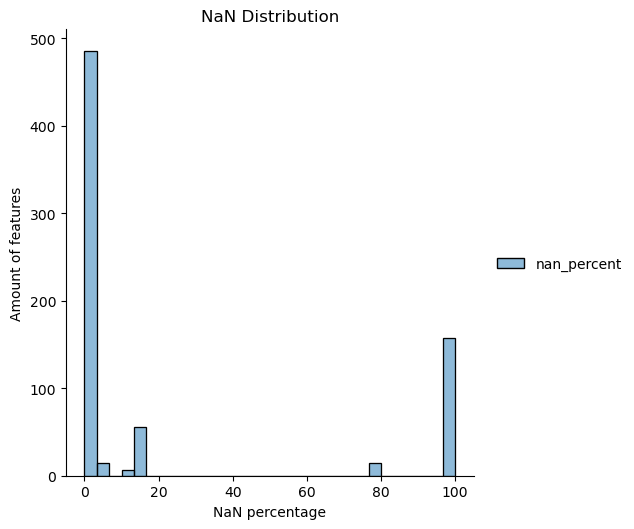

Total NaN percent:  25.561700628767856


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data=nandf)
plt.xlabel('NaN percentage')
plt.ylabel("Amount of features")
plt.title('NaN Distribution')
plt.show()

total_average_nans = nandf["nan_percent"].sum() / len(nandf)
print("Total NaN percent: ", total_average_nans)


In [28]:
def remove_nans_treshold(df:pd.DataFrame, treshold=70):
    #Create a mask of all columns(features) that have a very high NaN percent, and drop them. This is to make imputing more reliable. Might need to tune/revisit the idea later.
    percentdf = get_nan_percents(df)
    remove_mask = percentdf["nan_percent"] < treshold
    percentdf = percentdf.loc[remove_mask]
    okay_cols = percentdf["Column"]
    return df[okay_cols]
print(nandf.iloc[0]['nan_percent'],nandf.iloc[-1]["nan_percent"])
trimmed_df = remove_nans_treshold(df)
trimmed_df

0.0 99.96037642397226


go_gc_duration_seconds&catalogue:80&catalogue&0  \
instances timepoints                                                             
0         2023-03-24 14:09:48                                         0.000300   
          2023-03-24 14:09:53                                         0.000300   
          2023-03-24 14:09:58                                         0.000300   
          2023-03-24 14:10:03                                         0.000300   
          2023-03-24 14:10:08                                         0.000300   
...                                                                        ...   
88        2023-03-29 16:21:34                                         0.000311   
          2023-03-29 16:21:39                                         0.000311   
          2023-03-29 16:21:44                                         0.000311   
          2023-03-29 16:21:49                                         0.000311   
          2023-03-29 16:21:54                                         0.000311   

                               go_gc_duration_seconds&catalogue:80&catalogue&0.25  \
instances timepoints                                                                
0         2023-03-24 14:09:48                                           0.000317    
          2023-03-24 14:09:53                                           0.000317    
          2023-03-24 14:09:58                                           0.000317    
          2023-03-24 14:10:03                                           0.000317    
          2023-03-24 14:10:08                                           0.000317    
...                                                                          ...    
88        2023-03-29 16:21:34                                           0.000347    
          2023-03-29 16:21:39                                           0.000347    
          2023-03-29 16:21:44                                           0.000347    
          2023-03-29 16:21:49                                           0.000347    
          2023-03-29 16:21:54                                           0.000345    

                               go_gc_duration_seconds&catalogue:80&catalogue&0.5  \
instances timepoints                                                               
0         2023-03-24 14:09:48                                           0.000325   
          2023-03-24 14:09:53                                           0.000325   
          2023-03-24 14:09:58                                           0.000325   
          2023-03-24 14:10:03                                           0.000325   
          2023-03-24 14:10:08                                           0.000325   
...                                                                          ...   
88        2023-03-29 16:21:34                                           0.000392   
          2023-03-29 16:21:39                                           0.000392   
          2023-03-29 16:21:44                                           0.000392   
          2023-03-29 16:21:49                                           0.000392   
          2023-03-29 16:21:54                                           0.000391   

                               go_gc_duration_seconds&catalogue:80&catalogue&0.75  \
instances timepoints                                                                
0         2023-03-24 14:09:48                                           0.000337    
          2023-03-24 14:09:53                                           0.000337    
          2023-03-24 14:09:58                                           0.000337    
          2023-03-24 14:10:03                                           0.000337    
          2023-03-24 14:10:08                                           0.000337    
...                                                                          ...    
88        2023-03-29 16:21:34                                           0.000476    


In [5]:
#Imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
knn_imputed = imputer.fit_transform(trimmed_df)


In [6]:
knn_imputed_df = pd.DataFrame(knn_imputed, columns=trimmed_df.columns, index=trimmed_df.index)

works
